In [1]:
import librosa
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

C:\Users\Arnulf\Anaconda3\lib\site-packages\librosa\core\audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [15]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (1 entries)


In [2]:
# load music
y, sr = librosa.load("mix.wav", mono=True, duration=2408.448/4, sr=16000)
# Play it back!
#IPython.display.Audio(data=y, rate=sr)

In [25]:
plt.figure((12,4))
#plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Input')

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

#Spectrogram

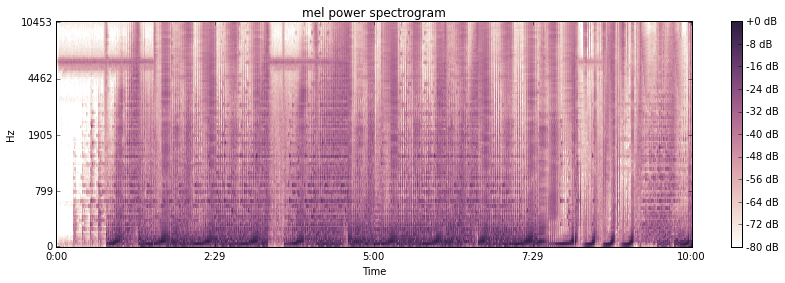

In [6]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

#Constant-Q

In [3]:
CQ = librosa.core.cqt(y, sr=sr, hop_length=2048, fmin=None, n_bins=80, bins_per_octave=12, tuning=None, resolution=2, aggregate=None, norm=1, sparsity=0.01)

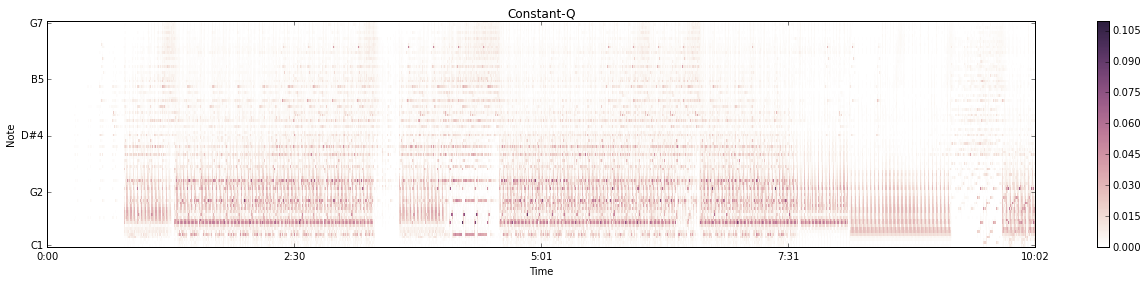

In [9]:
# plot the constant-q
plt.figure(figsize=(18,4))

librosa.display.specshow(CQ, sr=sr, x_axis='time', y_axis='cqt_note', hop_length=2048)

plt.title('Constant-Q')
plt.colorbar()

plt.tight_layout()

#CQ Recurrence Matrix

In [4]:
R_CQ = librosa.segment.recurrence_matrix(CQ, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)

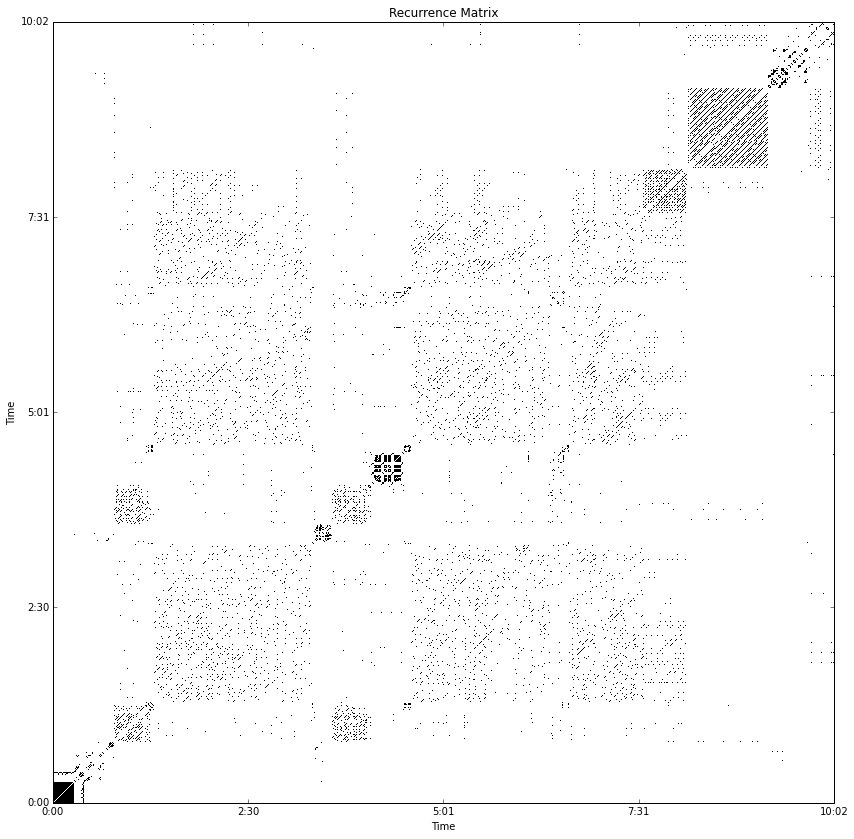

In [18]:
plt.figure(figsize=(14,14))

librosa.display.specshow(R_CQ, sr=sr/4, x_axis='time', y_axis='time', aspect='equal')

plt.title('Recurrence Matrix')

# Chromagram

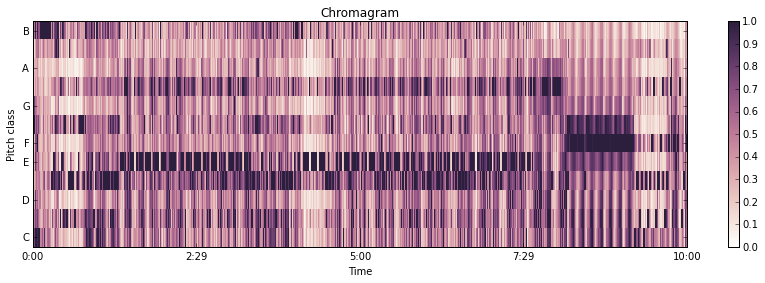

In [14]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

In [17]:
%xdel CQ

#Chromagram Recurrence Matrix

In [ ]:
R_C = librosa.segment.recurrence_matrix(C, k=None, width=1, sym=True)

In [ ]:
# Make a new figure
plt.figure(figsize=(12,12))

librosa.display.specshow(R_C, aspect='equal')

plt.title('Recurrence Matrix')

#Calculate Novelty-Function

In [7]:
from scipy import signal
from scipy import misc

In [5]:
kernel_size = 40
kernel = np.zeros([2*kernel_size+1, 2*kernel_size+1], dtype='int')
# create the kernel
kernel[:kernel_size, :kernel_size] = 1
kernel[kernel_size+1:, kernel_size+1:] = 1
kernel[kernel_size+1:, :kernel_size] = -1
kernel[:kernel_size, kernel_size+1:] = -1

In [ ]:
plt.figure(figsize=(4,4))

librosa.display.specshow(kernel, aspect='equal')

In [120]:
def correlate2d_diagonal(matrix, kernel):
    assert np.shape(matrix)[0] == np.shape(matrix)[1]
    assert np.shape(kernel)[0] == np.shape(kernel)[1]
    length = np.shape(matrix)[0]
    L = np.shape(kernel)[0]//2
    
    result = np.zeros(length)
    for i in range(length):
        for k in range(-L, L):
            if i+k < 0 or i+k >= length:
                break
            for l in range(-L, L):
                if i+l < 0 or i+l >= length:
                    break
                result[i] = result[i] + matrix[i+l, i+k] * kernel[L+l, L+k]
    return result

In [8]:
#filtered = signal.convolve2d(R_CQ, kernel, boundary='fill', mode='same', fillvalue=0)
filtered = signal.fftconvolve(R_CQ, kernel, mode='same')

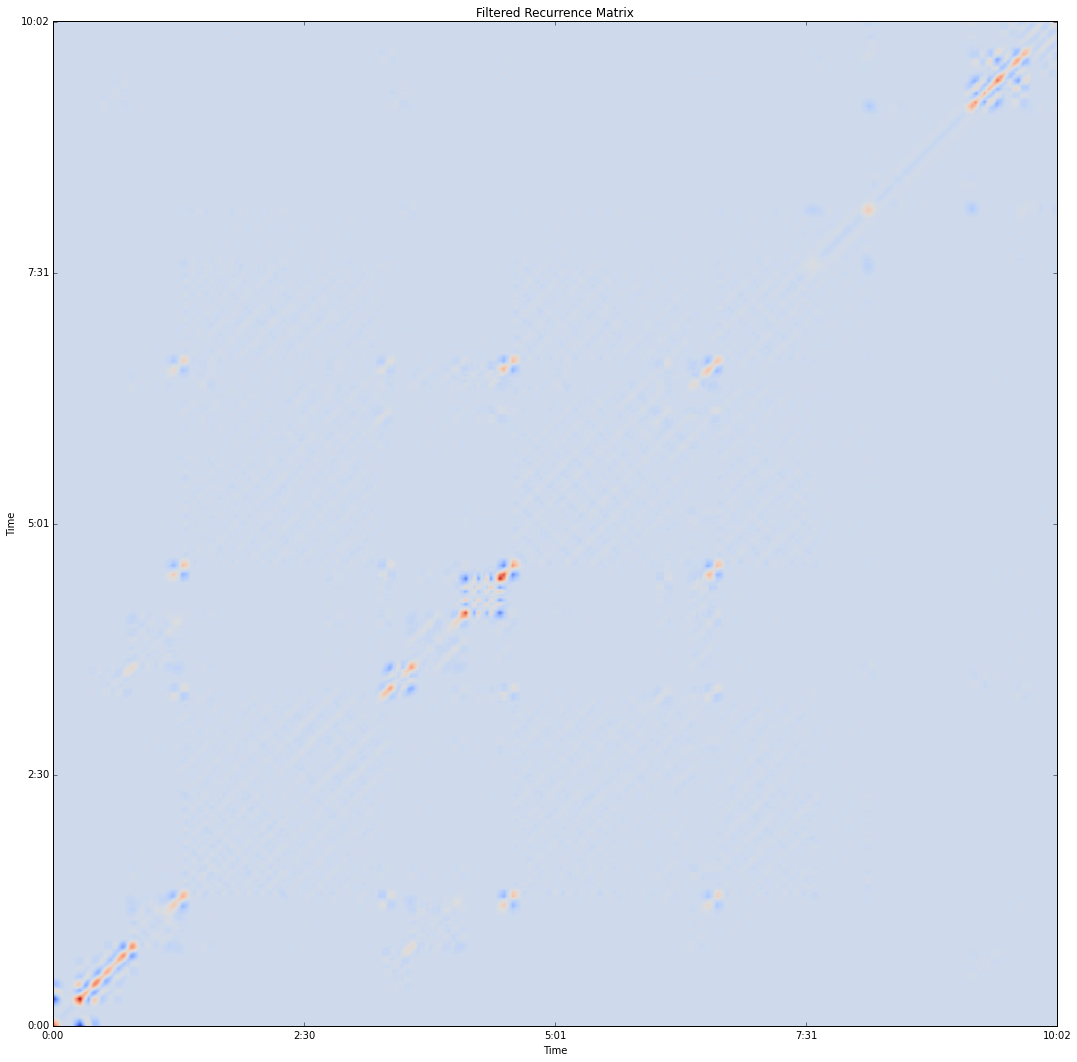

In [9]:
plt.figure(figsize=(18,18))

librosa.display.specshow(filtered, sr=sr/4, x_axis='time', y_axis='time', aspect='equal')

plt.title('Filtered Recurrence Matrix')

In [128]:
novelty = correlate2d_diagonal(R_CQ, kernel)

In [10]:
novelty = filtered.diagonal()

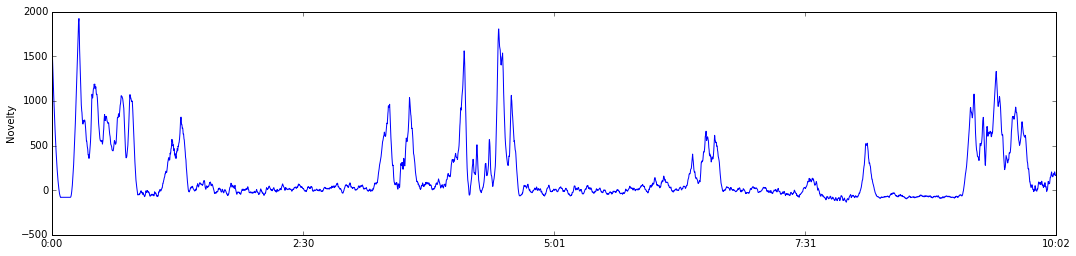

In [21]:
plt.figure(figsize=(18,4))
plt.plot(novelty)
plt.ylabel('Novelty')
locs = np.arange(0, len(novelty))
plt.xlim([locs[0], locs[-1]])
librosa.display.time_ticks(locs, librosa.core.samples_to_time(locs, sr=sr/2048), n_ticks=5)
plt.show()

In [36]:
LAG = librosa.segment.recurrence_to_lag(R_CQ, pad=True, axis=-1)
print(np.shape(LAG))

(9376, 4688)
